In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import noise
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

# Paweł Maczuga - Lab 11

# Algorytm Gorver'a (niezoptymalizowany)

In [22]:
def add_oracle_2(circ):
    circ.x(1)
    circ.toffoli(0, 1, 2)
    circ.x(1)

In [23]:
n = 2
x_reg = QuantumRegister(n)
y_reg = QuantumRegister(1)
circ_book = QuantumCircuit(x_reg, y_reg)

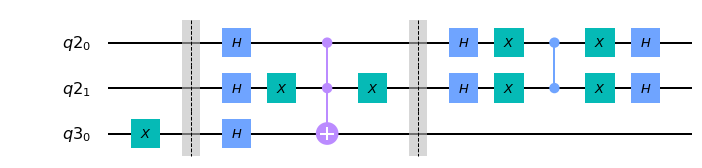

In [24]:
circ_book.x(y_reg[0])

circ_book.barrier(range(n+1))
for i in range(n+1):
    circ_book.h(i)

add_oracle_2(circ_book)
circ_book.barrier()
for i in range(n):
    circ_book.h(i)
for i in range(n):
    circ_book.x(i)
circ_book.cz(0, 1)
for i in range(n):
    circ_book.x(i)
for i in range(n):
    circ_book.h(i)

circ_book.draw()

In [28]:
def run(circ, backend, n):
    c_reg = ClassicalRegister(n)
    qc = circ.copy()
    qc.add_register(c_reg)
    qc.barrier(range(n))
    qc.measure(range(n), range(n))
    job = execute(qc, backend, shots=1024)
    result = job.result()
    return result

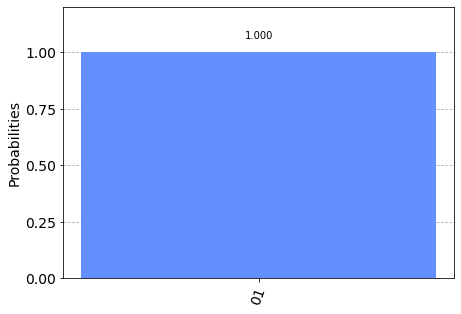

In [29]:
backend_sim = Aer.get_backend('qasm_simulator')
result_sim = run(circ_book, backend_sim, n)
plot_histogram(result_sim.get_counts())

In [30]:
provider = IBMQ.get_provider(group='open')
backend = provider.get_backend('ibmq_essex')
result = run(circ_book, backend, n)

In [38]:
result.get_counts()

{'11': 96, '00': 102, '10': 60, '01': 766}

# Opis metody i wyniki

Stworzenie 2 kubitowego rejestru i 4 prostych  obwodów do mierzenia każdego z 4 podstawowych stanów (00, 01, 10, 11)

In [68]:
# Generate the calibration circuits
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [69]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
       ░ ┌─┐   
q7_0: ─░─┤M├───
       ░ └╥┘┌─┐
q7_1: ─░──╫─┤M├
       ░  ║ └╥┘
c9_0: ════╩══╬═
             ║ 
c9_1: ═══════╩═
               

Circuit mcalcal_01
      ┌───┐ ░ ┌─┐   
q7_0: ┤ X ├─░─┤M├───
      └───┘ ░ └╥┘┌─┐
q7_1: ──────░──╫─┤M├
            ░  ║ └╥┘
c9_0: ═════════╩══╬═
                  ║ 
c9_1: ════════════╩═
                    

Circuit mcalcal_10
            ░ ┌─┐   
q7_0: ──────░─┤M├───
      ┌───┐ ░ └╥┘┌─┐
q7_1: ┤ X ├─░──╫─┤M├
      └───┘ ░  ║ └╥┘
c9_0: ═════════╩══╬═
                  ║ 
c9_1: ════════════╩═
                    

Circuit mcalcal_11
      ┌───┐ ░ ┌─┐   
q7_0: ┤ X ├─░─┤M├───
      ├───┤ ░ └╥┘┌─┐
q7_1: ┤ X ├─░──╫─┤M├
      └───┘ ░  ║ └╥┘
c9_0: ═════════╩══╬═
                  ║ 
c9_1: ════════════╩═
                    



In [70]:
state_labels

['00', '01', '10', '11']

Stworzenie modelu szumu

In [79]:
noise_model = noise.NoiseModel()
for qi in range(2):
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])

Wykonanie obwodów w symulatorze z szumem

In [80]:
# Execute the calibration circuits
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1024, noise_model=noise_model)
cal_results = job.result()

Wyliczenie macierzy kalibracji (calibration matrix)

In [81]:
# Calculate the calibration matrix with the noise model
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.78613281 0.22851562 0.20800781 0.05859375]
 [0.11328125 0.68359375 0.02050781 0.19042969]
 [0.09277344 0.02050781 0.68945312 0.1875    ]
 [0.0078125  0.06738281 0.08203125 0.56347656]]


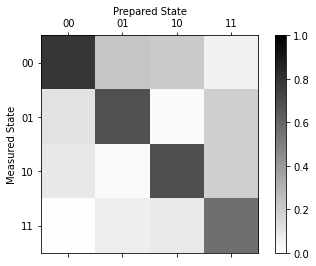

In [82]:
# Plot the calibration matrix
meas_fitter.plot_calibration()

Zaaplikowanie macierzy kalibracji do wyników z algorytmu Grover'a. 

In [83]:
# Results without mitigation
raw_counts = result.get_counts()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result)
mitigated_counts = mitigated_results.get_counts(0)

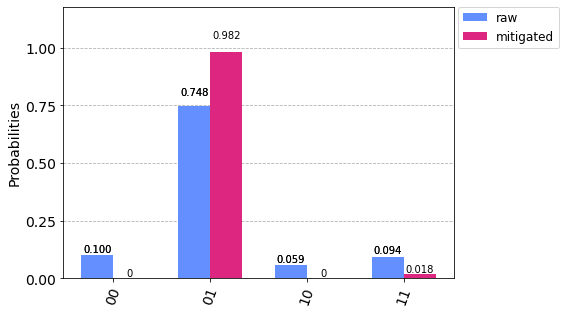

In [84]:
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])

Jak widać zastosowanie metody Measurement Error Mitigation znacznie polepszyło wyniki. Prawie 100%-owa dokładność.

Dlaczego taka duża poprawa? Po przemnożeniu macierzy kalibracji przez idealny wynik z symulatora dostalibyśmy wynik zaszumiony. Czyli możemy się spodziwać, że jesteśym w stanie zrobić coś odwrotnego - wziąć zaszumiony wynik z rzeczywistej maszyny i dzięki macierzy kalbiracji dostać wynik idealny (albo mu bliski). To właśnie robi kilka ostatnich linijek kodu, co jak widać działa i rzeczywiście daje znaczącą poprawę. 